In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from difflib import get_close_matches

LEAGUE = "ESP-La Liga"
seasons = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']

CACHE_DIR = Path("data_cache/football_data_spain")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

TEAM_MAP_FD_TO_UNDERSTAT = {
    "Ath Madrid": "Atletico Madrid",
    "Ath Bilbao": "Athletic Club",
    "Betis": "Real Betis",
    "Sociedad": "Real Sociedad",
    "Valladolid": "Real Valladolid",
    "Espanol": "Espanyol",
    "Celta": "Celta Vigo",
    "Vallecano": "Rayo Vallecano",

    # comunes
    "Alaves": "Alaves",
    "Almeria": "Almeria",
    "Barcelona": "Barcelona",
    "Cadiz": "Cadiz",
    "Elche": "Elche",
    "Getafe": "Getafe",
    "Girona": "Girona",
    "Granada": "Granada",
    "Huesca": "Huesca",
    "Las Palmas": "Las Palmas",
    "Leganes": "Leganes",
    "Levante": "Levante",
    "Mallorca": "Mallorca",
    "Osasuna": "Osasuna",
    "Real Madrid": "Real Madrid",
    "Sevilla": "Sevilla",
    "Valencia": "Valencia",
    "Villarreal": "Villarreal",
}

def map_team_fd_to_understat(name: str) -> str:
    name = str(name).strip()
    return TEAM_MAP_FD_TO_UNDERSTAT.get(name, name)

def understat_season_to_fd_code(season_year: str) -> str:
    # '2018' -> '1819', ..., '2025' -> '2526'
    y = int(season_year)
    yy = y % 100
    yy2 = (y + 1) % 100
    return f"{yy:02d}{yy2:02d}"

def load_fd_sp1(season_code: str) -> pd.DataFrame:
    parquet_path = CACHE_DIR / f"SP1_{season_code}.parquet"
    if parquet_path.exists():
        return pd.read_parquet(parquet_path)

    url = f"https://www.football-data.co.uk/mmz4281/{season_code}/SP1.csv"
    df_fd = pd.read_csv(url)
    df_fd["Date"] = pd.to_datetime(df_fd["Date"], dayfirst=True, errors="coerce")

    # Guarda cache (requiere pyarrow instalado)
    df_fd.to_parquet(parquet_path, index=False)
    return df_fd

def suggest_team_matches(unmatched_names, candidate_names, n=3):
    cand_list = sorted(set(candidate_names))
    out = {}
    for t in sorted(set(unmatched_names)):
        out[t] = get_close_matches(t, cand_list, n=n, cutoff=0.6)
    return out

print("Celda 1 OK ✅")


Celda 1 OK ✅


In [17]:
fd_frames = []
season_map = {}

for s in seasons:
    code = understat_season_to_fd_code(s)
    season_map[s] = code
    df_fd = load_fd_sp1(code)
    df_fd["understat_season"] = s
    df_fd["fd_season_code"] = code
    fd_frames.append(df_fd)

odds_fd = pd.concat(fd_frames, ignore_index=True)

need_cols = ["Date", "HomeTeam", "AwayTeam", "B365H", "B365D", "B365A"]
missing = [c for c in need_cols if c not in odds_fd.columns]
if missing:
    raise ValueError(f"Faltan columnas en Football-Data: {missing}")

odds_1x2 = odds_fd[need_cols].dropna(subset=need_cols).copy()

odds_1x2["match_date"] = pd.to_datetime(odds_1x2["Date"], dayfirst=True, errors="coerce").dt.date
odds_1x2["home_team_clean"] = odds_1x2["HomeTeam"].map(map_team_fd_to_understat)
odds_1x2["away_team_clean"] = odds_1x2["AwayTeam"].map(map_team_fd_to_understat)

print("Seasons (Understat -> FootballData code):", season_map)
print("odds_1x2 shape:", odds_1x2.shape)
display(odds_1x2.head(3))
print("Teams FD (mapped) sample:", sorted(set(odds_1x2["home_team_clean"]))[:15])


Seasons (Understat -> FootballData code): {'2018': '1819', '2019': '1920', '2020': '2021', '2021': '2122', '2022': '2223', '2023': '2324', '2024': '2425', '2025': '2526'}
odds_1x2 shape: (2888, 9)


,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,match_date,home_team_clean,away_team_clean
0,2018-08-17,Betis,Levante,1.66,4.0,5.0,2018-08-17,Real Betis,Levante
1,2018-08-17,Girona,Valladolid,1.75,3.6,5.0,2018-08-17,Girona,Real Valladolid
2,2018-08-18,Barcelona,Alaves,1.11,10.0,21.0,2018-08-18,Barcelona,Alaves


Teams FD (mapped) sample: ['Alaves', 'Almeria', 'Athletic Club', 'Atletico Madrid', 'Barcelona', 'Cadiz', 'Celta Vigo', 'Eibar', 'Elche', 'Espanyol', 'Getafe', 'Girona', 'Granada', 'Huesca', 'Las Palmas']


In [18]:
import soccerdata as sd

understat = sd.Understat("ESP-La Liga", seasons)
df = understat.read_schedule()

print("df cargado ✅")
print("shape:", df.shape)
display(df.head(3))


[02/12/26 23:04:40] INFO     Saving cached data to                                                   ]8;id=869876;file:///Users/mariovelezcanizares/Library/Python/3.9/lib/python/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=734409;file:///Users/mariovelezcanizares/Library/Python/3.9/lib/python/site-packages/soccerdata/_common.py#249\249]8;;\
                             /Users/mariovelezcanizares/soccerdata/data/Understat                                  

                    WARNING  /Users/mariovelezcanizares/Library/Python/3.9/lib/python/site-packages ]8;id=681330;file:///Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=947327;file:///Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/warnings.py#109\109]8;;\
                             /soccerdata/_common.py:143: UserWarning: Season id "2021" is                          
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

df cargado ✅
shape: (3040, 17)


league_id  season_id  \
league      season game                                                     
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid         4       2018   
                   2018-08-17 Real Betis-Levante             4       2018   
                   2018-08-18 Barcelona-Alaves               4       2018   

                                                      game_id  \
league      season game                                         
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid     9957   
                   2018-08-17 Real Betis-Levante         9958   
                   2018-08-18 Barcelona-Alaves           9961   

                                                                    date  \
league      season game                                                    
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid 2018-08-17 21:15:00   
                   2018-08-17 Real Betis-Levante     2018-08-17 23:15:00   
                   2018-08-18 Barcelona-Alaves       2018-08-18 23:15:00   

                                                      home_team_id  \
league      season game                                              
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid           223   
                   2018-08-17 Real Betis-Levante               153   
                   2018-08-18 Barcelona-Alaves                 148   

                                                      away_team_id  \
league      season game                                              
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid           231   
                   2018-08-17 Real Betis-Levante               151   
                   2018-08-18 Barcelona-Alaves                 158   

                                                       home_team  \
league      season game                                            
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid      Girona   
                   2018-08-17 Real Betis-Levante      Real Betis   
                   2018-08-18 Barcelona-Alaves         Barcelona   

                                                            away_team  \
league      season game                                                 
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid  Real Valladolid   
                   2018-08-17 Real Betis-Levante              Levante   
                   2018-08-18 Barcelona-Alaves                 Alaves   

                                                     away_team_code  \
league      season game                                               
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid            VAL   
                   2018-08-17 Real Betis-Levante                LEV   
                   2018-08-18 Barcelona-Alaves                  ALA   

                                                     home_team_code  \
league      season game                                               
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid            GIR   
                   2018-08-17 Real Betis-Levante                BET   
                   2018-08-18 Barcelona-Alaves                  BAR   

                                                      home_goals  away_goals  \
league      season game                                                        
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid           0           0   
                   2018-08-17 Real Betis-Levante               0           3   
                   2018-08-18 Barcelona-Alaves                 3           0   

                                                       home_xg   away_xg  \
league      season game                                                    
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid  0.626716  0.030934   
                   2018-08-17 Real Betis-Levante       1.00338   2.67481   
                   2018-08-18 Barcelona-Alaves         3.26753  0.248353   

                                                      is_

In [19]:
# CELDA 4 — Preparar df_stats (Understat limpio)
df_stats = df.copy()

# Llave de fecha (sin hora)
df_stats["match_date"] = pd.to_datetime(df_stats["date"], errors="coerce").dt.date

# Llaves de equipos (limpios)
df_stats["home_team_clean"] = df_stats["home_team"].astype(str).str.strip()
df_stats["away_team_clean"] = df_stats["away_team"].astype(str).str.strip()

# Filtrado recomendado si existen
if "has_data" in df_stats.columns:
    df_stats = df_stats[df_stats["has_data"] == True].copy()
if "is_result" in df_stats.columns:
    df_stats = df_stats[df_stats["is_result"] == True].copy()

# Mantener solo filas con datos clave
df_stats = df_stats.dropna(subset=[
    "match_date", "home_team_clean", "away_team_clean",
    "home_goals", "away_goals", "home_xg", "away_xg"
]).copy()

print("df_stats creado ✅", df_stats.shape)
display(df_stats[["match_date","home_team","away_team","home_goals","away_goals","home_xg","away_xg"]].head(5))


df_stats creado ✅ (2888, 20)

match_date  \
league      season game                                              
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid    2018-08-17   
                   2018-08-17 Real Betis-Levante        2018-08-17   
                   2018-08-18 Barcelona-Alaves          2018-08-18   
                   2018-08-18 Celta Vigo-Espanyol       2018-08-18   
                   2018-08-18 Villarreal-Real Sociedad  2018-08-18   

                                                         home_team  \
league      season game                                              
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid        Girona   
                   2018-08-17 Real Betis-Levante        Real Betis   
                   2018-08-18 Barcelona-Alaves           Barcelona   
                   2018-08-18 Celta Vigo-Espanyol       Celta Vigo   
                   2018-08-18 Villarreal-Real Sociedad  Villarreal   

                                                              away_team  \
league      season game                                                   
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid    Real Valladolid   
                   2018-08-17 Real Betis-Levante                Levante   
                   2018-08-18 Barcelona-Alaves                   Alaves   
                   2018-08-18 Celta Vigo-Espanyol              Espanyol   
                   2018-08-18 Villarreal-Real Sociedad    Real Sociedad   

                                                        home_goals  \
league      season game                                              
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid             0   
                   2018-08-17 Real Betis-Levante                 0   
                   2018-08-18 Barcelona-Alaves                   3   
                   2018-08-18 Celta Vigo-Espanyol                1   
                   2018-08-18 Villarreal-Real Sociedad           1   

                                                        away_goals   home_xg  \
league      season game                                                        
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid             0  0.626716   
                   2018-08-17 Real Betis-Levante                 3   1.00338   
                   2018-08-18 Barcelona-Alaves                   0   3.26753   
                   2018-08-18 Celta Vigo-Espanyol                1  0.428686   
                   2018-08-18 Villarreal-Real Sociedad           2   1.39716   

                                                         away_xg  
league      season game                                           
ESP-La Liga 1819   2018-08-17 Girona-Real Valladolid    0.030934  
                   2018-08-17 Real Betis-Levante         2.67481  
                   2018-08-18 Barcelona-Alaves          0.248353  
                   2018-08-18 Celta Vigo-Espanyol       0.647286  
                   2018-08-18 Villarreal-Real Sociedad  0.410646

In [20]:
# CELDA 5 — Merge stats + odds
df_merged = df_stats.merge(
    odds_1x2[["match_date", "home_team_clean", "away_team_clean", "B365H", "B365D", "B365A"]],
    on=["match_date", "home_team_clean", "away_team_clean"],
    how="left"
)

has_odds = ~df_merged[["B365H","B365D","B365A"]].isna().any(axis=1)
print(f"Match rate cuotas 1X2: {has_odds.mean():.2%} ({has_odds.sum()} / {len(df_merged)})")

display(df_merged.loc[has_odds, ["match_date","home_team","away_team","B365H","B365D","B365A"]].head(5))

# Reporte de equipos no matcheados
teams_understat = set(df_stats["home_team_clean"]).union(set(df_stats["away_team_clean"]))
teams_fd_mapped = set(odds_1x2["home_team_clean"]).union(set(odds_1x2["away_team_clean"]))

unmatched_understat = sorted(teams_understat - teams_fd_mapped)
print("\nEquipos Understat que NO matchean con Football-Data (después de TEAM_MAP):")
print(unmatched_understat, f"(total={len(unmatched_understat)})")


Match rate cuotas 1X2: 95.26% (2751 / 2888)


,match_date,home_team,away_team,B365H,B365D,B365A
0,2018-08-17,Girona,Real Valladolid,1.75,3.6,5.0
1,2018-08-17,Real Betis,Levante,1.66,4.0,5.0
2,2018-08-18,Barcelona,Alaves,1.11,10.0,21.0
3,2018-08-18,Celta Vigo,Espanyol,1.85,3.5,4.5
4,2018-08-18,Villarreal,Real Sociedad,2.04,3.4,3.8



Equipos Understat que NO matchean con Football-Data (después de TEAM_MAP):
['Real Oviedo', 'SD Huesca'] (total=2)


In [21]:
# CELDA 5 — Merge stats + odds
df_merged = df_stats.merge(
    odds_1x2[["match_date", "home_team_clean", "away_team_clean", "B365H", "B365D", "B365A"]],
    on=["match_date", "home_team_clean", "away_team_clean"],
    how="left"
)

has_odds = ~df_merged[["B365H","B365D","B365A"]].isna().any(axis=1)
print(f"Match rate cuotas 1X2: {has_odds.mean():.2%} ({has_odds.sum()} / {len(df_merged)})")

display(df_merged.loc[has_odds, ["match_date","home_team","away_team","B365H","B365D","B365A"]].head(5))

# Reporte de equipos no matcheados
teams_understat = set(df_stats["home_team_clean"]).union(set(df_stats["away_team_clean"]))
teams_fd_mapped = set(odds_1x2["home_team_clean"]).union(set(odds_1x2["away_team_clean"]))

unmatched_understat = sorted(teams_understat - teams_fd_mapped)
print("\nEquipos Understat que NO matchean con Football-Data (después de TEAM_MAP):")
print(unmatched_understat, f"(total={len(unmatched_understat)})")


Match rate cuotas 1X2: 95.26% (2751 / 2888)


,match_date,home_team,away_team,B365H,B365D,B365A
0,2018-08-17,Girona,Real Valladolid,1.75,3.6,5.0
1,2018-08-17,Real Betis,Levante,1.66,4.0,5.0
2,2018-08-18,Barcelona,Alaves,1.11,10.0,21.0
3,2018-08-18,Celta Vigo,Espanyol,1.85,3.5,4.5
4,2018-08-18,Villarreal,Real Sociedad,2.04,3.4,3.8



Equipos Understat que NO matchean con Football-Data (después de TEAM_MAP):
['Real Oviedo', 'SD Huesca'] (total=2)


In [22]:
# CELDA 6 — Dataset final para ML
df_merged["result"] = np.where(
    df_merged["home_goals"] > df_merged["away_goals"], "H",
    np.where(df_merged["home_goals"] < df_merged["away_goals"], "A", "D")
)

df_merged["pH_raw"] = 1 / df_merged["B365H"]
df_merged["pD_raw"] = 1 / df_merged["B365D"]
df_merged["pA_raw"] = 1 / df_merged["B365A"]

s = df_merged["pH_raw"] + df_merged["pD_raw"] + df_merged["pA_raw"]
df_merged["pH"] = df_merged["pH_raw"] / s
df_merged["pD"] = df_merged["pD_raw"] / s
df_merged["pA"] = df_merged["pA_raw"] / s
df_merged["vig"] = s - 1

df_merged["xg_diff"] = df_merged["home_xg"] - df_merged["away_xg"]
df_merged["total_goals"] = df_merged["home_goals"] + df_merged["away_goals"]

has_odds = ~df_merged[["B365H","B365D","B365A"]].isna().any(axis=1)
df_model = df_merged.loc[has_odds].copy()

print("df_model ✅", df_model.shape)
display(df_model.head(5))

teams_model = sorted(set(df_model["home_team_clean"]).union(set(df_model["away_team_clean"])))
print("\nN° equipos:", len(teams_model))
print("Equipos:", teams_model)

print("\nDistribución H/D/A:")
print(df_model["result"].value_counts(normalize=True))


df_model ✅ (2751, 33)


,league_id,season_id,game_id,date,home_team_id,away_team_id,home_team,away_team,away_team_code,home_team_code,...,result,pH_raw,pD_raw,pA_raw,pH,pD,pA,vig,xg_diff,total_goals
0,4,2018,9957,2018-08-17 21:15:00,223,231,Girona,Real Valladolid,VAL,GIR,...,D,0.571429,0.277778,0.200000,0.544629,0.264750,0.190620,0.049206,0.595782,0
1,4,2018,9958,2018-08-17 23:15:00,153,151,Real Betis,Levante,LEV,BET,...,A,0.602410,0.250000,0.200000,0.572410,0.237550,0.190040,0.052410,-1.67143,3
2,4,2018,9961,2018-08-18 23:15:00,148,158,Barcelona,Alaves,ALA,BAR,...,H,0.900901,0.100000,0.047619,0.859212,0.095373,0.045415,0.048520,3.019177,3
3,4,2018,9959,2018-08-18 19:15:00,152,141,Celta Vigo,Espanyol,ESP,CEL,...,D,0.540541,0.285714,0.222222,0.515548,0.272504,0.211948,0.048477,-0.2186,2
4,4,2018,9960,2018-08-18 21:15:00,154,140,Villarreal,Real Sociedad,SOC,VIL,...,A,0.490196,0.294118,0.263158,0.467980,0.280788,0.251232,0.047472,0.986514,3



N° equipos: 26
Equipos: ['Alaves', 'Almeria', 'Athletic Club', 'Atletico Madrid', 'Barcelona', 'Cadiz', 'Celta Vigo', 'Eibar', 'Elche', 'Espanyol', 'Getafe', 'Girona', 'Granada', 'Las Palmas', 'Leganes', 'Levante', 'Mallorca', 'Osasuna', 'Rayo Vallecano', 'Real Betis', 'Real Madrid', 'Real Sociedad', 'Real Valladolid', 'Sevilla', 'Valencia', 'Villarreal']

Distribución H/D/A:
result
H    0.445656
A    0.286441
D    0.267903
Name: proportion, dtype: float64


In [23]:
# CELDA 7 — Asegurar df_model listo para análisis/modelos
if "df_model" not in globals():
    raise NameError("No existe df_model. Ejecuta las celdas anteriores (merge + features) antes de seguir.")

use_cols = ["match_date","home_team_clean","away_team_clean","home_goals","away_goals",
            "home_xg","away_xg","xg_diff","total_goals",
            "B365H","B365D","B365A","pH","pD","pA","vig","result"]

missing = [c for c in use_cols if c not in df_model.columns]
if missing:
    raise KeyError(f"Faltan columnas en df_model: {missing}")

dfA = df_model.dropna(subset=["B365H","B365D","B365A","pH","pD","pA","xg_diff","result"]).copy()
dfA = dfA.sort_values("match_date").reset_index(drop=True)

print("dfA (análisis/modelos) shape:", dfA.shape)
display(dfA.head(3))


dfA (análisis/modelos) shape: (2751, 33)


,league_id,season_id,game_id,date,home_team_id,away_team_id,home_team,away_team,away_team_code,home_team_code,...,result,pH_raw,pD_raw,pA_raw,pH,pD,pA,vig,xg_diff,total_goals
0,4,2018,9957,2018-08-17 21:15:00,223,231,Girona,Real Valladolid,VAL,GIR,...,D,0.571429,0.277778,0.200000,0.544629,0.264750,0.190620,0.049206,0.595782,0
1,4,2018,9958,2018-08-17 23:15:00,153,151,Real Betis,Levante,LEV,BET,...,A,0.602410,0.250000,0.200000,0.572410,0.237550,0.190040,0.052410,-1.67143,3
2,4,2018,9961,2018-08-18 23:15:00,148,158,Barcelona,Alaves,ALA,BAR,...,H,0.900901,0.100000,0.047619,0.859212,0.095373,0.045415,0.048520,3.019177,3


In [24]:
# CELDA 8 — Correlación odds vs xG
corr = dfA[["pH","pD","pA","B365H","B365D","B365A","xg_diff","home_xg","away_xg"]].corr(numeric_only=True)

print("Correlación con xg_diff (positivo = favorito local en xG):")
display(corr[["xg_diff"]].sort_values("xg_diff", ascending=False))


Correlación con xg_diff (positivo = favorito local en xG):


,xg_diff
xg_diff,1.000000
home_xg,0.792268
pH,0.524703
B365A,0.450764
B365D,0.241415
pD,-0.227817
B365H,-0.440062
pA,-0.514891
away_xg,-0.712444


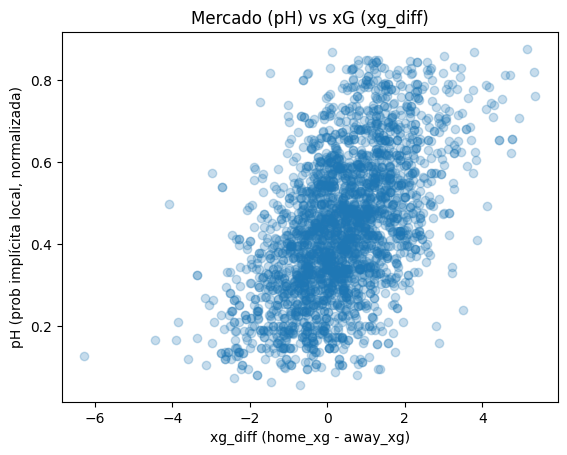

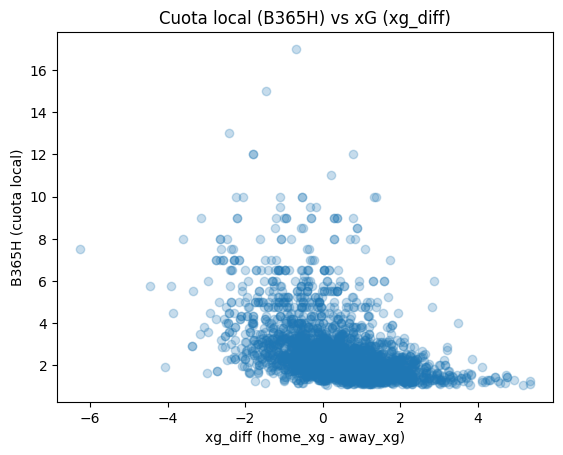

In [25]:
import matplotlib.pyplot as plt

# pH vs xg_diff
plt.figure()
plt.scatter(dfA["xg_diff"], dfA["pH"], alpha=0.25)
plt.xlabel("xg_diff (home_xg - away_xg)")
plt.ylabel("pH (prob implícita local, normalizada)")
plt.title("Mercado (pH) vs xG (xg_diff)")
plt.show()

# B365H vs xg_diff
plt.figure()
plt.scatter(dfA["xg_diff"], dfA["B365H"], alpha=0.25)
plt.xlabel("xg_diff (home_xg - away_xg)")
plt.ylabel("B365H (cuota local)")
plt.title("Cuota local (B365H) vs xG (xg_diff)")
plt.show()


In [26]:
# CELDA 10 — Logistic Regression multiclase (H/D/A)


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# Features (simples y fuertes)
X = dfA[["pH","pD","pA","xg_diff","vig"]].copy()
y = dfA["result"].copy()

# Split temporal: entrenamos con pasado, testeamos con futuro
split_idx = int(len(dfA) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

clf = LogisticRegression(
    multi_class="multinomial",
    max_iter=2000
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)
pred = clf.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("LogLoss:", round(log_loss(y_test, proba, labels=clf.classes_), 4))
print("\nReporte:")
print(classification_report(y_test, pred))

print("\nMatriz de confusión (filas=real, columnas=pred):")
display(pd.DataFrame(confusion_matrix(y_test, pred, labels=clf.classes_),
                     index=[f"real_{c}" for c in clf.classes_],
                     columns=[f"pred_{c}" for c in clf.classes_]))

# Importancia aproximada (coeficientes por clase)
coef = pd.DataFrame(clf.coef_, columns=X.columns, index=clf.classes_)
print("\nCoeficientes (señal/impacto por clase):")
display(coef)


[02/12/26 23:04:44] WARNING  /Users/mariovelezcanizares/Library/Python/3.9/lib/python/site-packages ]8;id=622624;file:///Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=189356;file:///Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/warnings.py#109\109]8;;\
                             /sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class'                 
                             was deprecated in version 1.5 and will be removed in 1.7. From then                   
                             on, it will always use 'multinomial'. Leave it to its default value to                
                             avoid this warning.                                                                   
                               warnings.warn(                                                                      
                                                                                                                   

Accuracy: 0.6189
LogLoss: 0.8598

Reporte:
              precision    recall  f1-score   support

           A       0.59      0.65      0.62       164
           D       0.48      0.17      0.25       134
           H       0.66      0.83      0.74       253

    accuracy                           0.62       551
   macro avg       0.57      0.55      0.54       551
weighted avg       0.59      0.62      0.58       551


Matriz de confusión (filas=real, columnas=pred):


,pred_A,pred_D,pred_H
real_A,107,12,45
real_D,46,23,65
real_H,29,13,211



Coeficientes (señal/impacto por clase):


,pH,pD,pA,xg_diff,vig
A,-0.454336,-0.598352,1.017601,-0.734893,0.001791
D,-0.510454,0.979816,-0.379511,0.010502,-0.012076
H,0.964790,-0.381464,-0.638090,0.724391,0.010285


In [27]:
# CELDA 11 — Rolling features por equipo (últimos 5 partidos)
dfR = dfA[["match_date","home_team_clean","away_team_clean","home_goals","away_goals","home_xg","away_xg","pH","pD","pA","vig"]].copy()
dfR = dfR.sort_values("match_date").reset_index(drop=True)

# Unificamos en formato "partidos por equipo" (home y away) para calcular rolling
home_rows = dfR[["match_date","home_team_clean","home_goals","home_xg"]].rename(
    columns={"home_team_clean":"team","home_goals":"goals_for","home_xg":"xg_for"}
)
away_rows = dfR[["match_date","away_team_clean","away_goals","away_xg"]].rename(
    columns={"away_team_clean":"team","away_goals":"goals_for","away_xg":"xg_for"}
)

long = pd.concat([home_rows, away_rows], ignore_index=True).sort_values(["team","match_date"])

# Rolling (shift para NO usar el partido actual)
N = 5
long["roll_goals_for"] = long.groupby("team")["goals_for"].shift(1).rolling(N).mean().reset_index(level=0, drop=True)
long["roll_xg_for"]    = long.groupby("team")["xg_for"].shift(1).rolling(N).mean().reset_index(level=0, drop=True)

# Tomamos las features rolling para home y away en cada partido
home_feat = long.rename(columns={"team":"home_team_clean",
                                 "roll_goals_for":"home_roll_goals",
                                 "roll_xg_for":"home_roll_xg"})[["match_date","home_team_clean","home_roll_goals","home_roll_xg"]]

away_feat = long.rename(columns={"team":"away_team_clean",
                                 "roll_goals_for":"away_roll_goals",
                                 "roll_xg_for":"away_roll_xg"})[["match_date","away_team_clean","away_roll_goals","away_roll_xg"]]

dfG = dfR.merge(home_feat, on=["match_date","home_team_clean"], how="left") \
        .merge(away_feat, on=["match_date","away_team_clean"], how="left")

print("dfG shape:", dfG.shape)
display(dfG.head(3))

dfG shape: (4803, 15)


,match_date,home_team_clean,away_team_clean,home_goals,away_goals,home_xg,away_xg,pH,pD,pA,vig,home_roll_goals,home_roll_xg,away_roll_goals,away_roll_xg
0,2018-08-17,Girona,Real Valladolid,0,0,0.626716,0.030934,0.544629,0.264750,0.190620,0.049206,NaN,NaN,1.0,1.013829
1,2018-08-17,Real Betis,Levante,0,3,1.00338,2.67481,0.572410,0.237550,0.190040,0.052410,NaN,NaN,1.2,1.142747
2,2018-08-18,Barcelona,Alaves,3,0,3.26753,0.248353,0.859212,0.095373,0.045415,0.048520,NaN,NaN,0.8,0.989708


In [28]:
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error

# Dataset con features disponibles
dfG2 = dfG.dropna(subset=["home_roll_goals","home_roll_xg","away_roll_goals","away_roll_xg"]).copy()

Xg = dfG2[["pH","pD","pA","vig","home_roll_goals","home_roll_xg","away_roll_goals","away_roll_xg"]]
yg = dfG2["home_goals"]

split_idx = int(len(dfG2)*0.8)
Xg_train, Xg_test = Xg.iloc[:split_idx], Xg.iloc[split_idx:]
yg_train, yg_test = yg.iloc[:split_idx], yg.iloc[split_idx:]

goal_model = PoissonRegressor(alpha=0.0001, max_iter=2000)
goal_model.fit(Xg_train, yg_train)

pred_mean = goal_model.predict(Xg_test)  # media esperada de goles local (lambda)
mae = mean_absolute_error(yg_test, pred_mean)

print("MAE (goles local):", round(mae, 4))
display(pd.DataFrame({"real_home_goals": yg_test.values, "pred_mean_home_goals": pred_mean}).head(10))


MAE (goles local): 0.9031


,real_home_goals,pred_mean_home_goals
0,0,1.061361
1,1,1.274260
2,1,1.702598
3,1,1.580070
4,0,1.401736
5,0,0.863635
6,3,2.119007
7,1,1.390012
8,0,1.249224
9,1,1.831351


In [ ]:
# CELDA 13 — Simulador (stake fijo) robusto

# Checks
if "dfA" not in globals():
    raise NameError("Falta dfA. Ejecuta la celda 7.")
if "clf" not in globals():
    raise NameError("Falta clf (Logistic Regression). Ejecuta la celda 10.")

# Recalcular split dentro de la celda (evita variables viejas)
n = len(dfA)
split_idx = int(n * 0.8)

test = dfA.iloc[split_idx:].copy()
X_test = test[["pH","pD","pA","xg_diff","vig"]].copy()

print("len(dfA):", n, "| split_idx:", split_idx, "| len(test):", len(test))

if len(X_test) == 0:
    raise ValueError("X_test quedó vacío. Revisa que dfA tenga filas y el split sea correcto.")

# Probabilidades del modelo
proba = clf.predict_proba(X_test)
proba_df = pd.DataFrame(proba, columns=clf.classes_, index=test.index)

# Tabla de simulación
sim = test[["match_date","home_team_clean","away_team_clean","B365H","B365D","B365A","result"]].copy()
sim = sim.join(proba_df)

# Probabilidades mercado (ya normalizadas)
sim["mH"], sim["mD"], sim["mA"] = test["pH"].values, test["pD"].values, test["pA"].values

# Edge
sim["edge_H"] = sim["H"] - sim["mH"]
sim["edge_D"] = sim["D"] - sim["mD"]
sim["edge_A"] = sim["A"] - sim["mA"]

# Selección apuesta
TH = 0.03
edges = sim[["edge_H","edge_D","edge_A"]]
best = edges.idxmax(axis=1)

sim["bet"] = best.map({"edge_H":"H", "edge_D":"D", "edge_A":"A"})
sim["edge_best"] = edges.max(axis=1)
sim["place_bet"] = sim["edge_best"] >= TH

# Cuota según apuesta
sim["odds"] = np.where(sim["bet"]=="H", sim["B365H"],
               np.where(sim["bet"]=="D", sim["B365D"], sim["B365A"]))

# PnL stake fijo
stake = 1.0
sim["win"] = sim["place_bet"] & (sim["bet"] == sim["result"])
sim["pnl"] = np.where(sim["place_bet"],
                      np.where(sim["win"], stake*(sim["odds"]-1), -stake),
                      0.0)

sim["bankroll"] = sim["pnl"].cumsum()

# Métricas
n_bets = int(sim["place_bet"].sum())
pnl_total = float(sim["pnl"].sum())
roi = pnl_total / (stake * n_bets + 1e-9)

print("N° apuestas:", n_bets)
print("PnL total:", round(pnl_total, 2))
print("ROI:", round(roi, 4))

display(sim.loc[sim["place_bet"]].head(15))


len(dfA): 2751 | split_idx: 2200 | len(test): 551
N° apuestas: 537
PnL total: 187.98
ROI: 0.3501


,match_date,home_team_clean,away_team_clean,B365H,B365D,B365A,result,A,D,H,...,edge_H,edge_D,edge_A,bet,edge_best,place_bet,odds,win,pnl,bankroll
2200,2024-09-01,Getafe,Real Sociedad,3.50,2.90,2.38,D,0.231156,0.383020,0.385824,...,0.113899,0.054835,-0.168734,H,0.113899,True,3.50,False,-1.00,-1.00
2201,2024-09-01,Osasuna,Celta Vigo,2.45,3.25,3.00,H,0.541533,0.316381,0.142087,...,-0.246941,0.023114,0.223827,A,0.223827,True,3.00,False,-1.00,-2.00
2202,2024-09-01,Real Madrid,Real Betis,1.29,5.75,9.50,H,0.036384,0.147018,0.816597,...,0.081378,-0.017927,-0.063451,H,0.081378,True,1.29,True,0.29,-1.71
2203,2024-09-01,Sevilla,Girona,2.35,3.80,2.75,A,0.695355,0.231918,0.072727,...,-0.331646,-0.018154,0.349800,A,0.349800,True,2.75,True,1.75,0.04
2204,2024-09-13,Real Betis,Leganes,1.62,3.70,6.25,H,0.040562,0.187955,0.771483,...,0.182221,-0.070046,-0.112174,H,0.182221,True,1.62,True,0.62,0.66
2205,2024-09-14,Sevilla,Getafe,2.20,3.00,3.70,H,0.153985,0.338991,0.507025,...,0.077458,0.023975,-0.101433,H,0.077458,True,2.20,True,1.20,1.86
2206,2024-09-14,Real Sociedad,Real Madrid,4.75,3.90,1.67,A,0.640415,0.263768,0.095817,...,-0.101723,0.023174,0.078549,A,0.078549,True,1.67,True,0.67,2.53
2207,2024-09-14,Mallorca,Villarreal,2.45,3.40,2.88,A,0.774407,0.187472,0.038121,...,-0.350790,-0.092773,0.443563,A,0.443563,True,2.88,True,1.88,4.41
2208,2024-09-14,Espanyol,Alaves,2.63,3.20,2.80,H,0.422120,0.356552,0.221328,...,-0.140839,0.058897,0.081942,A,0.081942,True,2.80,False,-1.00,3.41
2209,2024-09-15,Atletico Madrid,Valencia,1.33,4.50,11.00,H,0.004648,0.063196,0.932156,...,0.226173,-0.145461,-0.080712,H,0.226173,True,1.33,True,0.33,3.74


In [31]:
# Requiere que ya exista 'sim' de la Celda 13
bets = sim[sim["place_bet"]].copy()

hit_rate = bets["win"].mean() if len(bets) else np.nan
print("Apuestas:", len(bets))
print("Hit rate (win% en apuestas):", round(hit_rate, 4))

# También útil: rendimiento económico
print("PnL total:", round(bets["pnl"].sum(), 2))
print("ROI:", round(bets["pnl"].sum() / (len(bets) + 1e-9), 4))

# Desglose por tipo de apuesta
display(bets.groupby("bet").agg(
    apuestas=("bet","size"),
    winrate=("win","mean"),
    pnl=("pnl","sum"),
    roi=("pnl", lambda s: s.sum()/(len(s)+1e-9))
).sort_values("pnl", ascending=False))


Apuestas: 537
Hit rate (win% en apuestas): 0.5531
PnL total: 187.98
ROI: 0.3501


,apuestas,winrate,pnl,roi
bet,,,,
A,168,0.559524,89.12,0.530476
H,224,0.696429,79.47,0.354777
D,145,0.324138,19.39,0.133724


¿Como hubiera evolucionado el bank roll si hubiera apostado con el modelo?

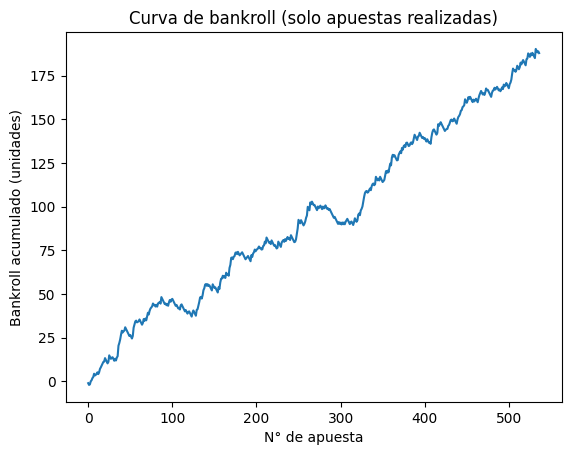

Máximo bankroll: 190.36
Mínimo bankroll: -2.0


In [32]:
import matplotlib.pyplot as plt

bets = sim[sim["place_bet"]].copy()

plt.figure()
plt.plot(bets["bankroll"].values)
plt.title("Curva de bankroll (solo apuestas realizadas)")
plt.xlabel("N° de apuesta")
plt.ylabel("Bankroll acumulado (unidades)")
plt.show()

print("Máximo bankroll:", round(bets["bankroll"].max(), 2))
print("Mínimo bankroll:", round(bets["bankroll"].min(), 2))
